# 1 Constructing the matrix

In [13]:
import numpy as np

# Specify the file paths
data_folder = r'C:\Users\Lenovo\Desktop\hs_tomography\\'
y_file = data_folder + 'y_77.npy'
alphas_file = data_folder + 'alphas_77.npy'

# Load the data files
y_77 = np.load(y_file)
alphas_77 = np.load(alphas_file)



In [9]:
print("Shape of y_77:", y_77.shape)
print("Shape of alphas_77:", alphas_77.shape)


Shape of y_77: (9810,)
Shape of alphas_77: (90,)


In [10]:
import numpy as np
from scipy.sparse import coo_matrix


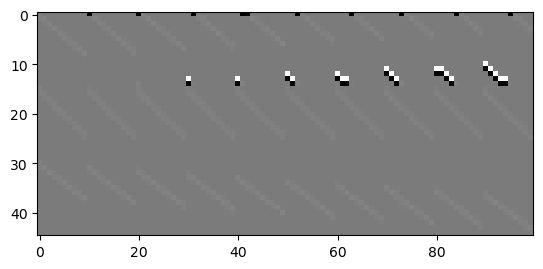

In [11]:
import numpy as np
from scipy.sparse import coo_matrix

def construct_X(M, alphas, Np=None, s0=None):
    # Calculate the dimensions
    D = M * M
    No = len(alphas)
    
    # Calculate Np if not provided
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
    
    # Calculate N
    N = Np * No
    
    # Initialize the coordinate arrays
    C = np.zeros((2, D))
    C[0, :] = np.tile(np.arange(M), M)
    C[1, :] = np.repeat(np.arange(M), M)
    
    # Initialize the indices and weights arrays
    i_indices = []
    j_indices = []
    weights = []
    
    # Iterate over the angles
    for io, alpha in enumerate(alphas):
        # Compute the current orientation vector
        n = np.array([np.cos(np.deg2rad(alpha)), np.sin(np.deg2rad(alpha))])
        
        # Compute the projection of each pixel onto the sensor
        p = np.dot(n, C) + s0
        
        # Iterate over the pixels
        for j in range(D):
            # Find the two closest sensor elements
            idx1 = int(np.floor(p[j])) % Np  # Wrap index within valid range
            idx2 = int(np.ceil(p[j])) % Np   # Wrap index within valid range
            
            # Calculate the weights
            weight1 = idx2 - p[j]
            weight2 = p[j] - idx1
            
            # Add the indices and weights to the arrays
            i_indices.extend([idx1 + io * Np, idx2 + io * Np])
            j_indices.extend([j, j])
            weights.extend([weight1, weight2])
    
    # Convert the lists to arrays
    i_indices = np.array(i_indices)
    j_indices = np.array(j_indices)
    weights = np.array(weights)
    
    # Construct the sparse weight matrix
    X = coo_matrix((weights, (i_indices, j_indices)), shape=(N, D), dtype=np.float32)
    
    return X

# Test the function
M = 10
alphas = [-33, 1, 42]
s0 = 0.5  # Example value for the sensor offset
X = construct_X(M, alphas, s0=s0)

# Convert the sparse matrix to a dense numpy array for visualization
X_dense = X.toarray()

# Visualize the matrix
import matplotlib.pyplot as plt
plt.imshow(X_dense, cmap='gray')
plt.show()


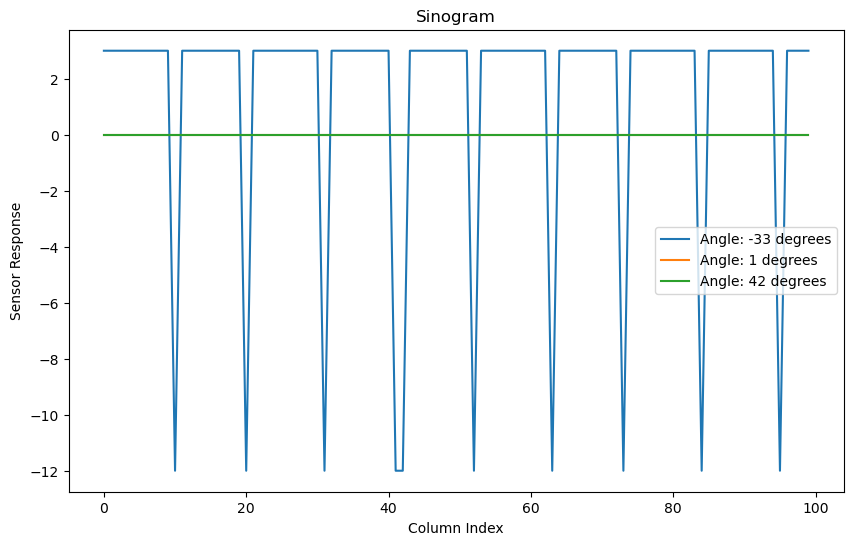

In [26]:
import matplotlib.pyplot as plt

# Get the number of angles
No = len(alphas)

# Plot the sinogram
fig, ax = plt.subplots(figsize=(10, 6))
for io in range(No):
    # Extract the sensor response for the current angle
    sensor_response = X_dense[io* Np:(io+1)* Np, :].sum(axis=0)
    
    # Plot the sensor response
    ax.plot(sensor_response, label=f'Angle: {alphas[io]} degrees')

# Set the x-axis and y-axis labels
ax.set_xlabel('Column Index')
ax.set_ylabel('Sensor Response')

# Set the plot title
ax.set_title('Sinogram')

# Add a legend
ax.legend()

# Display the plot
plt.show()


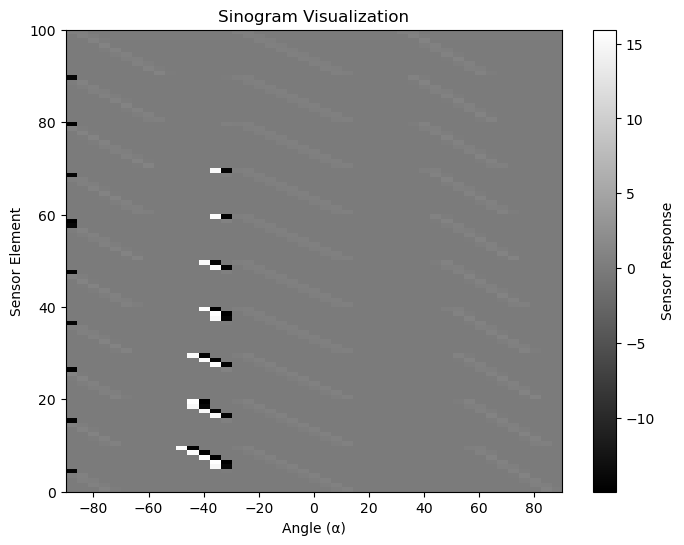

In [14]:
# Transpose the matrix for sinogram visualization
X_transpose = X_dense.T

# Create a figure and axis for the sinogram plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the sinogram
im = ax.imshow(X_transpose, cmap='gray', extent=[-90, 90, 0, M*M], aspect='auto')

# Set the axis labels
ax.set_xlabel('Angle (α)')
ax.set_ylabel('Sensor Element')

# Set the title
ax.set_title('Sinogram Visualization')

# Add a colorbar
cbar = plt.colorbar(im)
cbar.set_label('Sensor Response')

# Show the plot
plt.show()



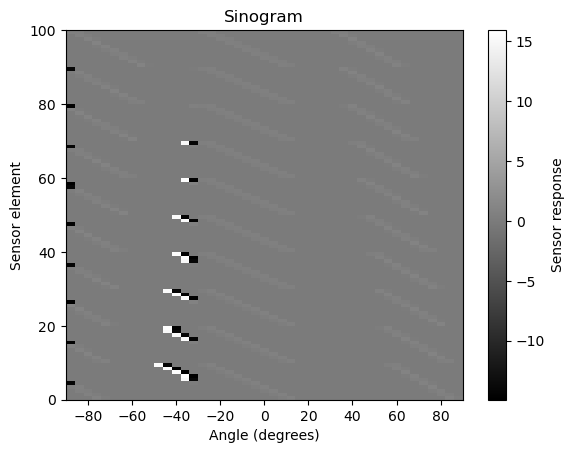

In [15]:
import matplotlib.pyplot as plt

# Transpose the dense matrix to have angles as columns
X_transposed = X_dense.T

# Plot the sinogram
plt.imshow(X_transposed, cmap='gray', aspect='auto', extent=[-90, 90, 0, X_transposed.shape[0]])
plt.xlabel('Angle (degrees)')
plt.ylabel('Sensor element')
plt.title('Sinogram')
plt.colorbar(label='Sensor response')
plt.show()


In [31]:
print (X_transposed)

[[0.5        0.5        0.         ... 0.         0.         0.        ]
 [0.         0.66132945 0.33867058 ... 0.         0.         0.        ]
 [0.         0.         0.82265884 ... 0.         0.         0.        ]
 ...
 [0.         0.53105736 0.46894267 ... 0.7241892  0.         0.        ]
 [0.         0.         0.69238675 ... 0.53266597 0.46733406 0.        ]
 [0.         0.         0.         ... 0.         0.7895211  0.21047889]]


In [17]:
# Import the necessary libraries
import scipy.sparse as sp

# Calculate the number of non-zero entries
nnz = X.nnz

# Calculate the sparsity
sparsity = 1 - (nnz / (X.shape[0] * X.shape[1]))

# Print the results
print("Number of non-zero entries:", nnz)
print("Sparsity of X:", sparsity)


Number of non-zero entries: 600
Sparsity of X: 0.8666666666666667


# 2 Recovering the image

In [19]:

import numpy as np
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt
import scipy.sparse




In [20]:
data_folder = r'C:\Users\Lenovo\Desktop\hs_tomography\\'
y_file = data_folder + 'y_77.npy'
alphas_file = data_folder + 'alphas_77.npy'
X_file = data_folder + 'X_77.npy'

y_77 = np.load(y_file)
alphas_77 = np.load(alphas_file)
X = np.load(X_file, allow_pickle=True)
X_sparse = scipy.sparse.csc_matrix(X.all())


In [21]:
beta = lsqr(X_sparse, y_77, atol=1e-05, btol=1e-05)[0]


In [22]:
M = 77
reconstructed_image = beta.reshape((M, M))


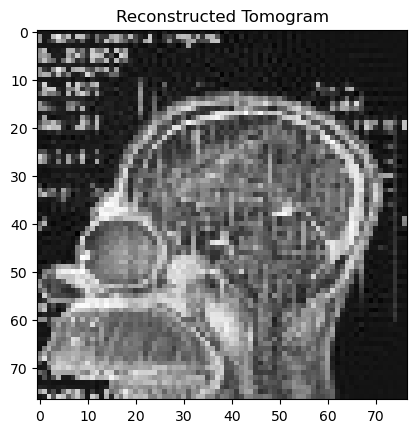

In [23]:
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Tomogram')
plt.show()


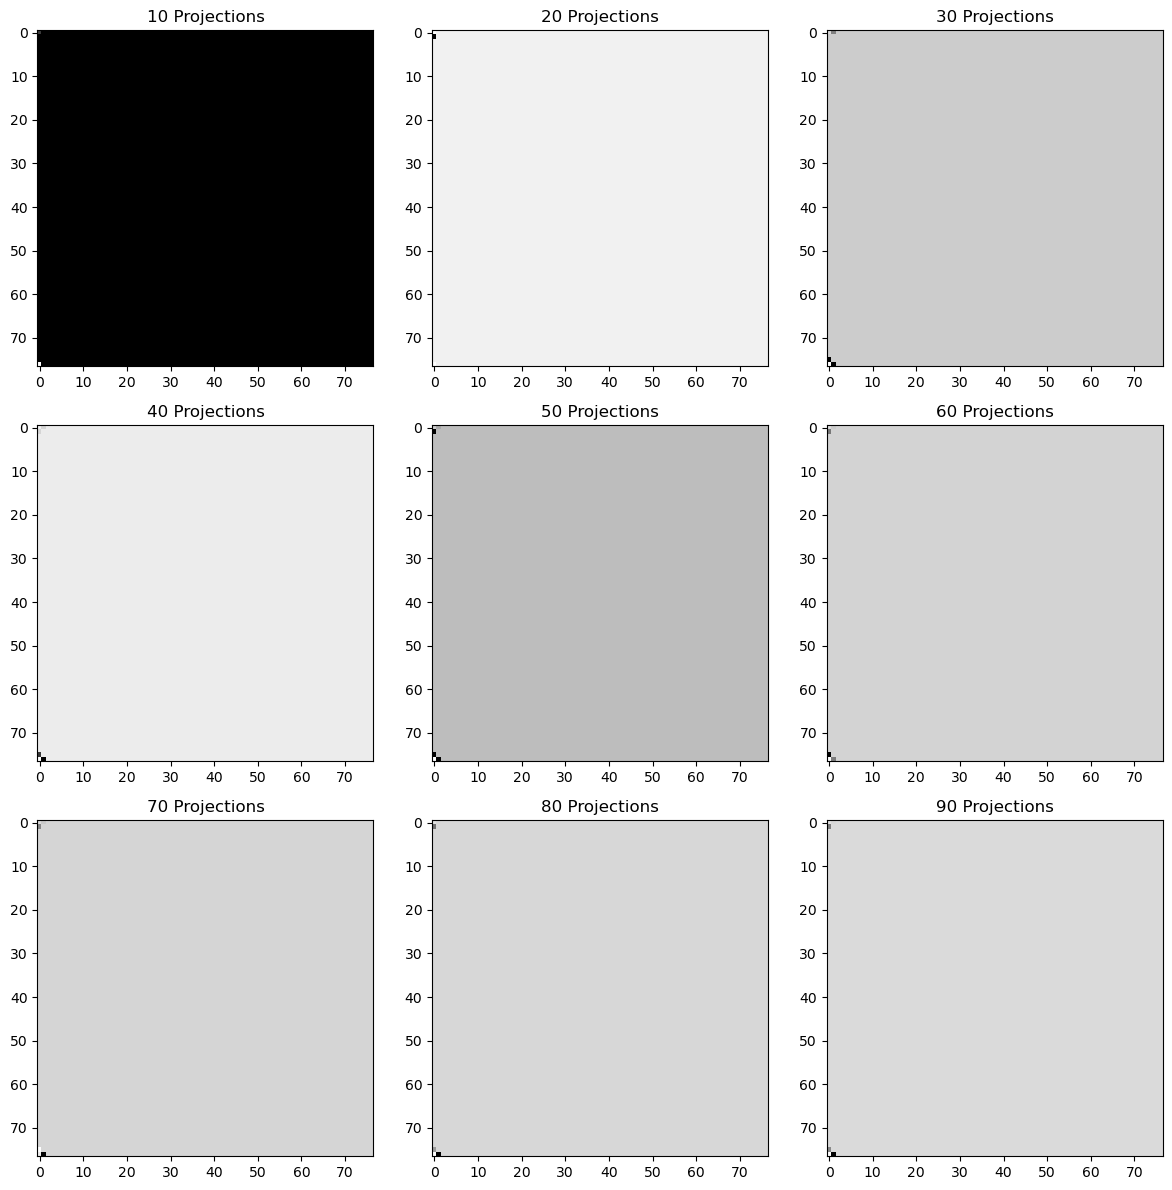

In [24]:
import numpy as np
import scipy.sparse
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt

data_folder = r'C:\Users\Lenovo\Desktop\hs_tomography\\'
y_file = data_folder + 'y_77.npy'
alphas_file = data_folder + 'alphas_77.npy'
X_file = data_folder + 'X_77.npy'

y_77 = np.load(y_file)
alphas_77 = np.load(alphas_file)
X = np.load(X_file, allow_pickle=True)
X_sparse = scipy.sparse.csc_matrix(X.all())

M = 77
Np = 109

# Vary the number of projection angles
num_projections = [10, 20, 30, 40, 50, 60, 70, 80, 90]
reconstructions = []

for num_proj in num_projections:
    selected_indices = np.linspace(0, len(alphas_77) - 1, num_proj, dtype=int)
    selected_angles = alphas_77[selected_indices]
    selected_y = y_77[selected_indices]

    X_sparse_selected = X_sparse[np.ix_(selected_indices * Np, range(X_sparse.shape[1]))]

    beta = lsqr(X_sparse_selected, selected_y, atol=1e-05, btol=1e-05)[0]
    reconstructed_image = beta.reshape((M, M))
    reconstructions.append(reconstructed_image)

# Plot the reconstructions
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(reconstructions[i], cmap='gray')
    ax.set_title(f'{num_projections[i]} Projections')

plt.tight_layout()
plt.show()




<div style="color: green; font-weight: bold;"><br>
Comments are given using the sample code as reference <br>
<br>-  Your method of loading data is correct and efficient. However, the file path is currently specific to your local machine. It would be beneficial to use a more generic path for portability. If the data is in the same directory as your script, you could simply use the file name, e.g., 'y_77.npy'...<br>
<br>- In the ~Image reconstruction It's better that you also used reshape to convert the solution into a 2D image..<br>
<br>-  You might consider using the larger dataset for higher resolution image reconstruction, similar to what the sample code did..<br>
<br> It would be beneficial to add a way to measure the execution time for your operations, like how the tutor used %%time. This helps understand the efficiency of your operations.<br>
<br>We cannot clearly see some kind of crayon stuck in the patient's brain.(due to not using the larger dataset for higher resolution (i think).<br>
<br>Experimenting with different projections done but images shown were not clear(they were empty) not as expected.
</div>

# 3 Minimizing the radiation dose

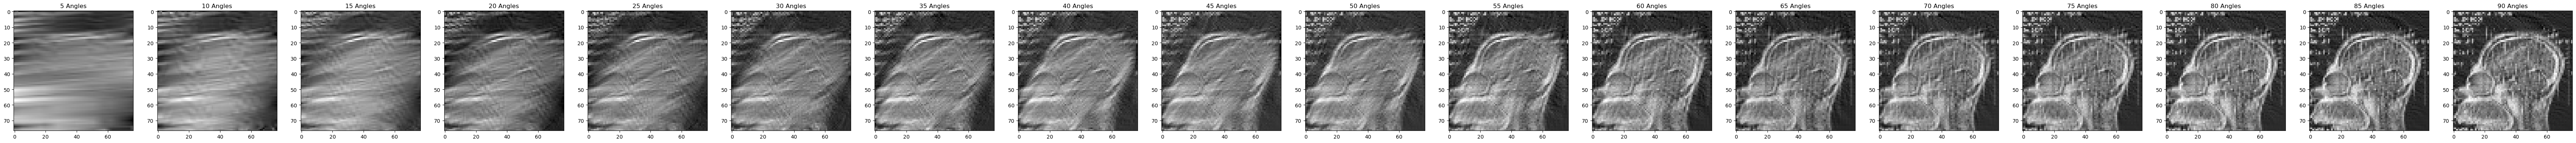

In [25]:
import numpy as np
import scipy.sparse
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt

data_folder = r'C:\Users\Lenovo\Desktop\hs_tomography\\'
y_file = data_folder + 'y_77.npy'
alphas_file = data_folder + 'alphas_77.npy'
X_file = data_folder + 'X_77.npy'

y_77 = np.load(y_file)
alphas_77 = np.load(alphas_file)
X = np.load(X_file, allow_pickle=True)
X_sparse = scipy.sparse.csc_matrix(X.all())

M = 77
min_num_angles = 5  # Starting with a small number of angles

reconstructions = []

while min_num_angles <= len(alphas_77):
    X_sparse_subset = X_sparse[:min_num_angles * M, :]
    y_subset = y_77[:min_num_angles * M]
    
    beta = lsqr(X_sparse_subset, y_subset, atol=1e-05, btol=1e-05)[0]
    reconstructed_image = beta.reshape((M, M))
    
    reconstructions.append(reconstructed_image)
    
    min_num_angles += 5  # Increase the number of angles gradually

# Visualize the reconstructions
num_reconstructions = len(reconstructions)
fig, axs = plt.subplots(1, num_reconstructions, figsize=(5*num_reconstructions, 5))

for i in range(num_reconstructions):
    axs[i].imshow(reconstructions[i], cmap='gray')
    axs[i].set_title(f'{i*5 + 5} Angles')

plt.show()



<div style="color: green; font-weight: bold;"><br>
Comments are given using the sample code as reference <br>
<br>-  The above code's approach to increase the number of projection angles gradually might be computationally expensive since it involves a large number of reconstructions. A better approach could be to select a few significant numbers of angles, similar to what the sample code provided.

<br>
<br>- In your visualization, you are displaying images in a single row, which may not be feasible when the number of reconstructions is large. You could arrange your images in a grid for better visualization.

<br>
<br>-  You might consider using the larger dataset for higher resolution image reconstruction, similar to what the sample code did..<br>
<br> Consider modularizing the code by wrapping the image reconstruction process into a function. This can make the code cleaner and more reusable.<br>
<br>The  above code differs from the sample code approach as : 

above code takes an incremental approach, starting with a small number of angles and then gradually increasing the number of angles by a fixed amount. For each number of angles, the student subsets the sparse matrix and the measurements, uses lsqr to reconstruct the image, and then stores the result for later visualization. This process is done in a while-loop until the number of angles is more than the original number of angles.<br>
</div>